# Projektvorstellung Image Classification

&copy; Daniel Schaudt, [Prof. Dr. Reinhold von Schwerin](https://www.thu.de/Reinhold.vonSchwerin), Technische Hochschule Ulm

In diesem Notebook soll aufgezeigt werden, wie mit modernen Deep Learning-Methoden Bilder maschinell erkannt und in vordefinierte Klassen unterteilt werden können. Dies geschieht beispielhaft an Röntgenbildern der Lunge, mit denen eine, durch COVID-19 ausgelöste Lungenentzündung aufgedeckt werden soll. Ein Blogpost von [Adrian Rosebrock](https://www.pyimagesearch.com/2020/03/16/detecting-covid-19-in-x-ray-images-with-keras-tensorflow-and-deep-learning/) lieferte die Inspiration dazu.

**Man beachte in diesem Zusammenhang unbedingt die Hinweise im oben genannten Blogpost, die auch hier gelten: es wird keineswegs die medizinische Sinnhaftigkeit der Methode behauptet! Diese müsste von Medizinern geprüft werden. Es geht hier lediglich darum, zu zeigen, was *technisch* möglich wäre.**

Der verwendete Technologie-Stack besteht im Kern aus [`Python`](https://www.python.org/) und der Bibliothek [`Tensorflow`](https://www.tensorflow.org/). Alle weiteren Bibliotheken dienen als Helfer für die Datenverarbeitung. Entgegen der vorherrschenden Meinung, dass für Deep Learning besonders viele Daten benötigt werden, kommt diese Demonstration mit nur wenigen Daten aus (154 Bilder insgesamt). Dadurch soll gezeigt werden, dass auch das eigenständige Sammeln und *Labeln* von Daten in einem Deep Learning-Projekt zum Erfolg führen kann.

**Anmerkungen:** 
* Deep Learning ist ein komplexes Thema! Das Ziel dieses Notebooks ist es, anhand eines einfachen Anwendungsfalles einen groben Überblick über eine spezielle Deep Learning-Methode zu geben, welcher von Lesern mit unterschiedlichem Hintergrund verstanden werden kann. Für interessierte Leser stellt dieses Notebook aber immer wieder Literaturreferenzen bereit, welche das Thema detaillierter aufarbeiten.
* Streng genommen benötigt man auch hier sehr viele Trainingsdaten, aber da wir auf ein *vortrainiertes Modell* zurückgreifen können (s.u.), kann man für die *spezielle Anwendung* mit wenigen Daten auskommen.

Um Datenprojekte strukturiert aufzubauen, bietet sich der Einsatz eines etablierten Vorgehensmodells an. Diese Projektvorstellung orientiert sich am [CRISP-DM-Modell](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining). Dieses Modell deckt die folgenden Projekt-Phasen ab:

![CRISP-DM](./images/Cross-Industry-Standard-Process-for-Data-Mining-CRISP-DM-12_s.png "CRISP-DM")


Um den Aufbau verständlich zu halten, entsprechen die Überschriften dieses Notebooks genau den Phasen des CRISP-DM-Prozesses. Die Kurzbeschreibung der Phasen in diesem Notebook entstammen aus [Pete Chapman et al](ftp://ftp.software.ibm.com/software/analytics/spss/support/Modeler/Documentation/14/UserManual/CRISP-DM.pdf).

## Business Understanding

> **Aus CRISP-DM 1.0:** *Diese erste Phase konzentriert sich auf das Verständnis der Projektziele und -anforderungen aus der Geschäftsperspektive. Dieses Wissen wird dann in eine Data-Mining-Problemdefinition und einen vorläufigen Plan umgewandelt, um
die Ziele zu erreichen.*

In Zeiten der Corona-Krise ist die Untersützung des medizinischen Fachpersonals von unschätzbarem Wert. Eine automatische Klassifikation von medizinischem Bildmaterial kann in vielen Bereichen einen Mehrwert schaffen. Im Fall Corona ist der Nutzen einer Klassifikation von Röntgenbildern der Lunge aber eher aus der Not heraus entstanden. Aufgrund der Knappheit von Corona-Tests, wurden in [China eine zeitlang die Corona-Fälle anhand von Symptomen und Röntgen/CT-Bildern klassifiziert](https://www.statnews.com/2020/02/20/experts-say-confusion-over-coronavirus-case-count-in-china-is-muddying-picture-of-spread/). Diese Art der Klassifikation ist fehleranfällig, da COVID-19 bedingte Lungenentzündungen (Pneumonie) nur schwer von anderen viralen Lungenentzündungen  zu unterscheiden sind.

**Nochmals: Die exemplarische Projektvorstellung in diesem Notebook erhebt nicht den Anspruch, einen medizinischen oder wissenschaftlichen Mehrwert zu bieten und dient lediglich Demonstrationszwecken. Es soll jedoch verdeutlicht werden, dass der aufgezeigte Anwendungsfall durchaus in der "realen Welt" verankert ist.**

## Data Understanding

> **Aus CRISP-DM 1.0:** *Die Phase Data Understanding beginnt mit der ersten Datensammlung und geht weiter mit Aktivitäten, die es ermöglichen, sich mit den Daten vertraut machen. Dazu gehören: Datenqualitätsprobleme zu identifizieren, erste Einblicke in die Daten zu gewinnen und/oder interessante Teilmengen zu entdecken, um Hypothesen über verborgene Informationen zu bilden.*

### Reproduzierbarkeit erreichen

Setzen diverser [Random Seeds](https://de.wikipedia.org/wiki/Seed_key) für determistisches Trainingsverhalten (d.h. zur Reproduzierbarkeit der Ergebnisse):

In [1]:
RSEED = 1742
import random
random.seed(RSEED)
from numpy.random import seed
seed(RSEED)
from tensorflow import random as tfrand
tfrand.set_seed(RSEED)

**Bemerkung** Leider erreicht man damit nur eine *lokale Reproduzierbarkeit*, d.h. die Ergebnisse auf einem bestimmten Rechner bleiben bei auch sonst unveränderten Modellparametern (s.u.) gleich. Rechnerübergreifend kommt hier wohl zum Tragen, was [Jason Brownlee](https://machinelearningmastery.com/reproducible-results-neural-networks-keras/) im Abschnitt *Randomness from a Sophisticated Model* schreibt. Daher ist zu erwarten, das jeder, der dieses Notebook in seiner gewählten Umgebung ausführt, andere Ergebnisse erhält, als die hier dargestellten (siehe auch die Bemerkung dazu im Abschnitt **Evaluation**). Ohnehin sollte man Brownlees Empfehlung folgen und zur Beurteilung der Performance des Modells dieses mehrfach ausführen (siehe auch den oben verlinkten Post).

### Import der Bibliotheken

Nachfolgend werden die benötigten Bibliotheken importiert. Eine kurze Information zu den wichtigsten Bibliotheken:
* [Tensorflow](https://www.tensorflow.org/): Open-source Machine Learning-Bibliothek, welche den Kern dieses Notebooks bildet. Mit Tensorflow werden die Deep Learning-Modelle erzeugt und trainiert. Genauer gesagt wird in diesem Notebook die High-Level API [Keras](https://www.tensorflow.org/guide/keras/overview) verwendet, welche seit Tensorflow 2.0 fest integriert ist.
* [scikit-learn](https://scikit-learn.org/stable/): Ebenfalls eine Machine Learning Bibliothek, welche sich eher für klassische ML-Ansätze eignet. In diesem Notebook wird die Bibliothek für die Evaluation des Modells verwendet.
* [mlxtend](http://rasbt.github.io/mlxtend/): Ein Beitrag von [Sebastian Raschka](https://sebastianraschka.com/) zur Erweiterung der Möglichkeiten zum maschinellen Lernen mit Python (auch sein [Blog](https://sebastianraschka.com/blog/index.html) ist es wert, angeschaut zu werden).
* [Pillow (PIL)](https://pillow.readthedocs.io/en/stable/): PIL steht für *Python Image Library* und kommt in diesem Notebook für die Darstellung und Verarbeitung von Bilddaten zum Einsatz.
* [matplotlib](https://matplotlib.org/index.html): Für Visualisierungen und Plots.
* [numpy](https://numpy.org/): Eine mächtige Bibliothek für wissenschaftliche Berechnungen. Wir verwenden in diesem Notebook die Array-Funktionalitäten von numpy.

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import densenet
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import pathlib
import IPython.display as display
import PIL
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline

### Laden der Bilddaten

> Die Bilder der COVID-19 erkranten Patienten entstammen einem Datensatz von [Jospeh Paul Cohen](https://github.com/ieee8023/covid-chestxray-dataset), abgeholt am 24.03.2020. Die Bilder der Patienten, welche keine Lungenentzündung aufweisen, stammen von [Kaggle's Chest X-Ray Images dataset](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia).

Um mit Daten zu arbeiten, müssen diese zuerst geladen werden. Die Bilddaten dieses Projekts liegen in folgender Ordnerstruktur vor:

```
data
├───train
│   ├───covid
│   └───normal
└───valid
    ├───covid
    └───normal
```

Die Ordner `train`und `valid` enthalten jeweils die Trainings- und Validierungsdaten. Die Unterordner `covid`und `normal` enthalten Bilddaten, welche den jeweiligen Klassen zugeordnet werden. Mit den Trainingsdaten wird das Modell trainiert und die Validierungsdaten dienen dazu, die *Generalisierungsfähigkeit* des Modells zu erproben. Generalisierung im ML-Kontext bedeutet, dass ein Modell nicht nur die bereits gesehenen Daten *auswendig* lernt, sondern aus den Daten gewonnenes Wissen auf neue, unbekannte Daten anwenden kann. 

Diese Art der Evaluation eines Modells wird als [*Holdout-Strategie*](https://www.kdnuggets.com/2017/08/dataiku-predictive-model-holdout-cross-validation.html) bezeichnet. Die korrekte Evaluation eines Modells könnte als der wichtigste Bereich im Machine Learning bezeichnet werden. Wer hier Fehler macht, wird nicht wissen, ob das Modell tatsächlich in der Praxis geeignet ist. Nähere Informationen dazu finden sich beispielsweise in Kapitel 5.2 des Buches [Deep Learning von Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html) oder in der [Scikit-learn Dokumentation](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation).

Das Laden der Bilddaten orientiert sich der Einfachheit halber an der offiziellen [Dokumentation](https://www.tensorflow.org/tutorials/load_data/images?hl=de) von Tensorflow.

Angeben des Pfades und Zählung der Anzahl der Bilder:

In [3]:
data_dir = pathlib.Path('./data')

In [4]:
train_image_count = len(list(data_dir.glob('train/*/*')))

In [5]:
train_image_count

134

In [6]:
valid_image_count = len(list(data_dir.glob('valid/*/*')))

In [7]:
valid_image_count

20

Die Klassennamen (*labels*) können aus den Ordnernamen extrahiert werden:

In [8]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('train/*')])
CLASS_NAMES

array(['normal', 'covid'], dtype='<U6')

Mit `display.display` kann beispielhaft ein Röntenbild ohne Symptome in Jupyter angezeigt werden: 

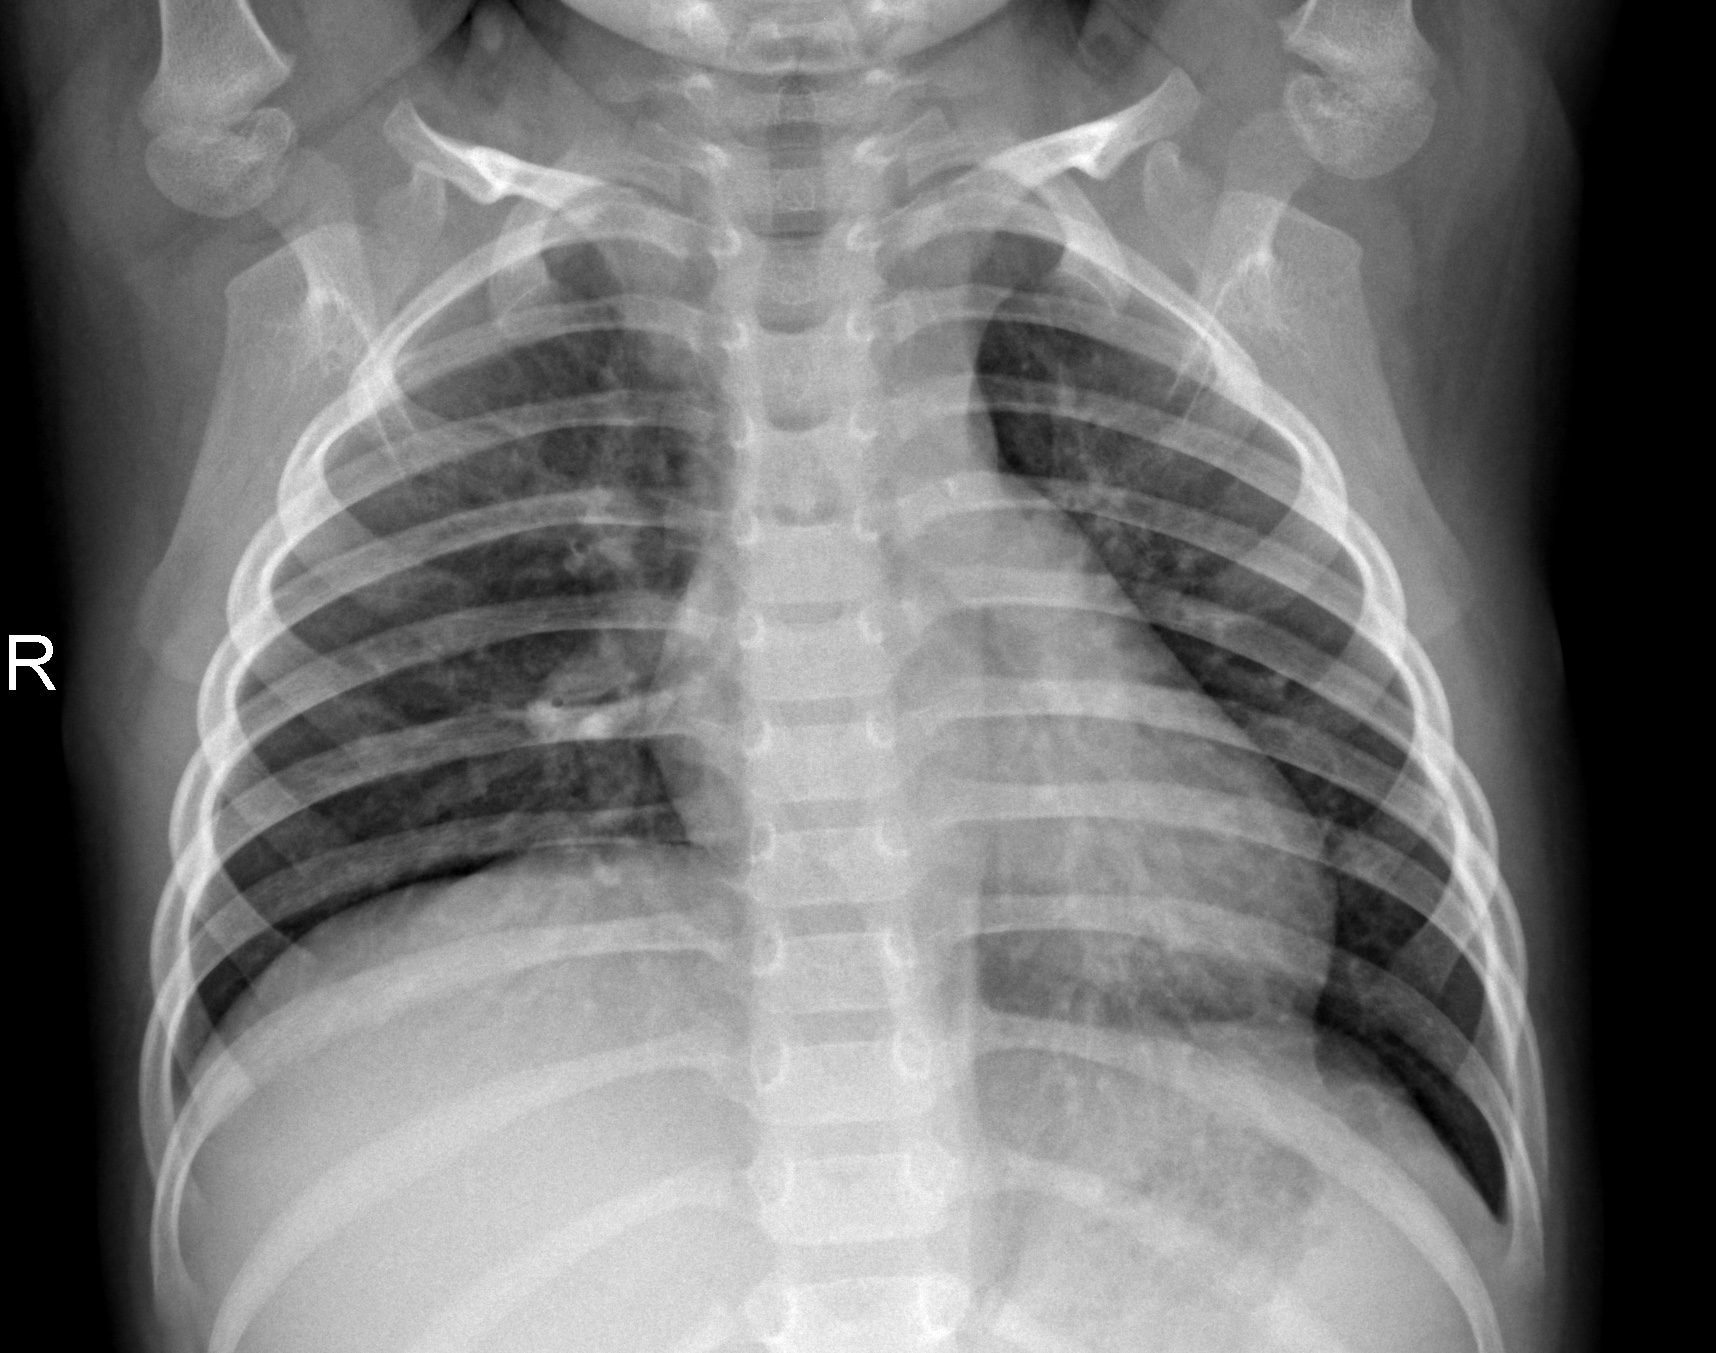

In [9]:
image_list = list(data_dir.glob('train/normal/*'))
display.display(Image.open(str(image_list[2])))

Dazu zum Vergleich ein Bild mit COVID-19 bedingter Lungenentzündung:

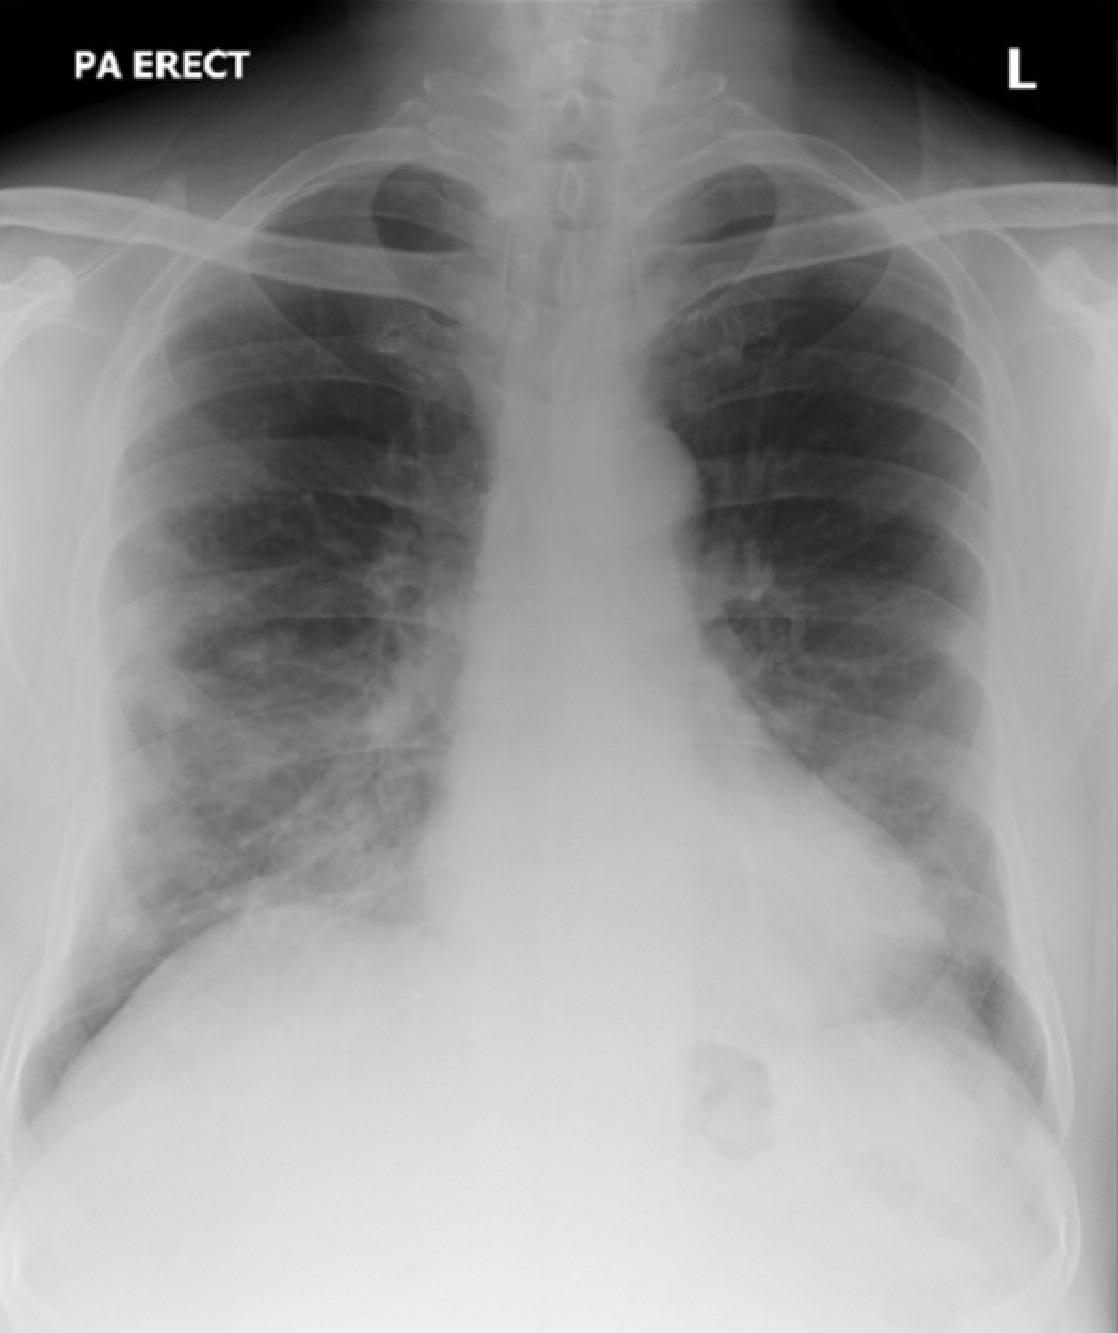

In [10]:
image_list = list(data_dir.glob('train/covid/*'))
display.display(Image.open(str(image_list[7])))

Ohne ein Medizinstudium und eine Facharztausbildung abgeschlossen zu haben, kann ein neutraler Betrachter mit diesen Bildern sicherlich nicht viel anfangen. Es ist unklar, welche Bildmerkmale bei der Klassifikation einer Lungenentzündung eine Rolle spielen.

## Data Preparation

> **Aus CRISP-DM 1.0:** *Die Phase Data Preparation umfasst alle Aktivitäten, die zur Erstellung des finalen Datensatzes aus den anfänglichen Rohdaten benötigt werden. Datenvorbereitungsaufgaben werden unter Umständen mehrfach und nicht
in vorgegebener Reihenfolge ausgeführt. Zu den Aufgaben gehören die Auswahl von Tabellen, Datensätzen und Attributen sowie die Transformation und Bereinigung von Daten für die Modellierung.*

In diesem Abschnitt werden die Bilddaten in eine Form gebracht, die dem Deep Learning-Modell als Input dient. Dies geschieht mit Hilfe von `keras.preprocessing`. Zunächst wird ein `ImageDataGenerator`-Objekt erstellt, welches dafür sorgt, dass die Werte ($\hat=$ *Pixelintensität*) der einzelnen Bildpunkte von \[0-255\] auf \[0-1\] skaliert werden. Das später verwendete neuronale Netz multipliziert diese initialen Bildpunkte mehrfach beim Durchlauf durch die Schichten des Modells und nochmals beim Update der Gewichte (Parameter) des Netzwerks. Durch die Skalierung der Eingabewerte wird die Stabilität des Trainingsprozesses erhöht. Dieses Phänomen ist auch als *Vanishing Gradient* oder *Exploding Gradient* bekannt. Nähere Informationen finden sich u.a. in [Yann LeCun et al.](http://yann.lecun.com/exdb/publis/pdf/lecun-98b.pdf).

In [11]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Folgende Parameter werden definiert:
* **Batchsize:** Die Batchsize gibt an, wieviele Bilder in einem *Durchgang* durch das neuronale Netz geleitet werden. Dieser Parameter ist im Wesentlichen aus zwei Gründen wichtig: 1) zur Speicheroptimierung und 2) für das Training des Modells. Die Wahl der Batchsize kann ein heikles Thema darstellen und hängt von vielen Faktoren ab. Eine Einführung geben u.a. [Michael Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html) oder Kapitel 8.1.3 von [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/optimization.html).
* **IMG_HEIGHT und IMAGE-WIDTH**: Auf diese Größe werden alle Bilder angepasst. Um ein neuronales Netz zu trainieren, müssen alle Bilder die gleiche Größe aufweisen.

In [12]:
BATCH_SIZE = 8
IMG_HEIGHT = 224
IMG_WIDTH = 224

Anschließend werden die Bilder mit `flow_from_directory()` aus den Ordnern geladen und in Batches unterteilt. Aus Gründen der Speicheroptimierung wird dazu ein [Python-Generator](https://wiki.python.org/moin/Generators) verwendet.

In [13]:
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/train',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 134 images belonging to 2 classes.


In [14]:
valid_data_gen = image_generator.flow_from_directory(directory=str(data_dir)+'/valid',
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=False,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES))

Found 20 images belonging to 2 classes.


Ein `Batch` der Bilder kann mit folgender Funktion angezeigt werden:

In [15]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(BATCH_SIZE/2,BATCH_SIZE/2,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

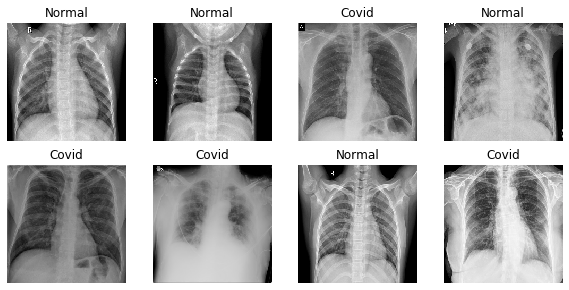

In [16]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

Damit sind die Daten für das Training und die anschließende Validierung mit Hilfe eines neuronalen Netzes vorbereitet.

## Modeling

> **Aus CRISP-DM 1.0:** *In dieser Phase werden verschiedene Modellierungstechniken ausgewählt und angewendet und ihre Parameter auf optimale Werte kalibriert. Normalerweise gibt es mehrere Techniken für denselben Data-Mining-Problemtyp. Einige Techniken haben spezifische Anforderungen an die Form der Daten. Daher ist es oft notwendig, zur Datenvorbereitungsphase zurückzugehen.*

In diesem Abschnitt wird das Deep Learning-Modell definiert und trainiert. Für Bilderkennungsaufgaben werden fast ausschließlich *Convolutional Neural Networks* (CNN) angewendet. Diese Netze eignen sich aufgrund ihrer *Architektur* besonders gut für die Aufgabenstellung. Sie erkennen mit selbsterlernten *Filtern* (Kernel) Muster in den Daten:

![CNN](./images/cnn.png "CNN")

> Bild aus [Adit Deshpande](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/), wo man eine verständliche Einführung in CNNs findet

Weitere Informationen zu neuronalen Netzen im Allgemeinen und CNN im Speziellen finden sich u.a. in folgender Literatur:
* Exzellente Videoeinführung zu NNs von 3Blue1Brown, unbedingt [anschauen!](https://www.youtube.com/watch?v=aircAruvnKk&list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)
* Grundlegendes Konzept von neuronalen Netzen mit interaktiven Beispielen und Visualisierungen: [Jay Alammar](https://jalammar.github.io/visual-interactive-guide-basics-neural-networks/)
* CNN-Basics mit anschaulichen Visualisierungen: [Adit Deshpande](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/)
* Intuition der Funktionsweise eines CNN: [Christopher Olah](https://colah.github.io/posts/2014-07-Conv-Nets-Modular/)

Folgende Parameter werden definiert:
* **EPOCHS:** Eine *Epoche* stellt einen kompletten Trainingslauf durch alle Trainingsdaten dar.
* **STEPS_PER_EPOCH:** Die *Schritte pro Epoche* stellt die Anzahl an Batches pro Durchlauf dar.
* **VALIDATION_STEPS:** Ist das gleiche wie `STEPS_PER_EPOCH`, aber für die Validierungsdaten.
* **INIT_LR:** Die initiale Lernrate des Modells. Eine weiterführende Erklärung zum Training des Modells findet sich u.a. in [Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html).

In [17]:
EPOCHS = 10
STEPS_PER_EPOCH = np.ceil(train_image_count/BATCH_SIZE)
VALIDATION_STEPS = np.ceil(valid_image_count/BATCH_SIZE)
INIT_LR = 5e-3

Nachfolgend wird das CNN-Modell definiert. Genauer gesagt handelt es sich hier um zwei Modelle: ein *baseModel* und ein *headModel*. Das *baseModel* ist ein bereits *vortrainiertes* Modell, welches Klassifikationen mit Millionen von Bildern ([ImageNet](http://www.image-net.org/)) erlernt hat (mathematisch gesehen wurden also die *Gewichte* der Verbindungen zwischen den Layern des Netzes bestimmt). Das *headModel* stellt quasi einen neuen *Aufsatz*, auch *Kopf* genannt, für das Basismodell bereit, welches für den hier gezeigten Anwendungsfall angepasst wird. 

Diese Technik wird als [Transfer Learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/) bezeichnet. Durch Transfer Learning können Deep Learning-Modelle schon mit sehr wenigen Daten trainiert werden. Intuitiv könnte man sagen, dass ein Modell den Großteil seines "Wissens" schon mitbringt und jetzt nur noch Feineinstellungen gemacht werden.

Das Basismodell ist ein [DenseNet](https://arxiv.org/abs/1608.06993):

In [18]:
baseModel = densenet.DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Mit `include_top=False` wird angezeigt, dass die letzten Layer des CNN nicht benötigt werden, da diese wie folgt als *headModel* selbst definiert werden:

In [19]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

Das *headModel* besteht im Kern aus zwei Fully-Connected-Layers, mit zwei Neuronen in der Ausgabeschicht. Diese entsprechen den Klassen *covid* und *normal* unserers Anwendungsfalles. Das Gesamtmodell wird dann in `model` zusammengefügt:

In [20]:
model = Model(inputs=baseModel.input, outputs=headModel)

Nun müssen die Layers des Basismodells noch *eingefroren* werden, damit deren Gewichte nicht durch das Gradientenupdate angepasst werden. Für weitere Informationen zum Training eines neuronalen Netzes wird erneut auf [Nielsen](http://neuralnetworksanddeeplearning.com/chap2.html) verwiesen.

In [21]:
for layer in baseModel.layers:
    layer.trainable = False

Die Anpassung der Gewichte des neuronalen Netzwerks erfolgt durch den *Adam*-Algorithmus, welcher eine Anpassung des stochastischen Gradientenverfahrens darstellt. Eine kurze Übersicht gibt der Blogpost von [Jason Brownlee](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) (aber man kann diesen auch einfach benutzen, ohne die Hintergründe genau zu kennen oder noch tiefer einsteigen bei [towards data science](https://towardsdatascience.com/adam-latest-trends-in-deep-learning-optimization-6be9a291375c) ...).

In [22]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

Eine Zusammenfassung des Modells erhält man mit `summary()`:

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

Die Zusammenfassung zeigt die Architektur des Netzwerks, also die Layer und deren Art von Beginn des Netzwerks (Inputlayer) bis zum Ende (Outputlayer). Weiterhin kann die Größe der Layer, sowie deren Verbindungen untersucht werden. Das baseModel besteht dabei vorwiegend aus Blöcken von Conv2D, BatchNormalization und Relu. Am unteren Ende der Zusammenfassung ist das headModel zu sehen, mit den vorher definierten Layers.

Abschließend folgt nun das Training des Modells:

In [24]:
H = model.fit(
    train_data_gen,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_data_gen,
    validation_steps=VALIDATION_STEPS,
    epochs=EPOCHS)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 17.0 steps, validate for 3.0 steps
Epoch 1/10
17/17 [==============================] - 27s 2s/step - loss: 1.1872 - accuracy: 0.6940 - val_loss: 0.6244 - val_accuracy: 0.7500
Epoch 2/10
17/17 [==============================] - 17s 1s/step - loss: 0.4046 - accuracy: 0.8657 - val_loss: 0.5849 - val_accuracy: 0.7500
Epoch 3/10
17/17 [==============================] - 16s 913ms/step - loss: 0.4237 - accuracy: 0.8582 - val_loss: 0.4485 - val_accuracy: 0.7500
Epoch 4/10
17/17 [==============================] - 15s 892ms/step - loss: 0.3308 - accuracy: 0.8284 - val_loss: 0.4765 - val_accuracy: 0.8000
Epoch 5/10
17/17 [==============================] - 12s 732ms/step - loss: 0.2483 - accuracy: 0.8881 - val_loss: 0.3550 - val_accuracy: 0.8500
Epoch 6/10
17/17 [==============================] - 15s 879ms/step - loss: 0.2489 - accuracy: 0.8881 - val_loss: 0.5411 - val_accuracy: 0.6500
Epoch 7/10
17/17 [==============================] - 1

## Evaluation

> **Aus CRISP-DM 1.0:** *In dieser Phase des Projekts wurde ein Modell erstellt, welches eine ausreichende Performance zu haben scheint. Bevor das Modell endgültig implementiert wird, ist es wichtig, das Modell, sowie die Schritte, die zur Erstellung des Modells geführt haben, gründlich zu evaluieren und zu überprüfen, um sicher zu sein, dass das Modell die Geschäftsziele ordnungsgemäß erreicht. Es soll sichergestellt werden, dass alle Geschäftsziele ausreichend berücksichtigt wurden. Am Ende dieser Phase sollte eine Entscheidung über die Verwendung der Data-Mining-Ergebnisse getroffen werden.*

In diesem Abschnitt wird die Klassifikationsperformance des Modells untersucht. Zu diesem Zweck werden exemplarisch ein paar einfache und weit verbreitete Metriken verwendet. Dazu werden zuerst die Vorhersagen des Modells der Validierungsdaten extrahiert. Diese erhält man mit `model.predict()`: 

In [25]:
predIdxs = model.predict(valid_data_gen)

Die `predict()`-Funktion gibt die Wahrscheinlichkeiten für jede Klasse zurück. Um eine binäre Entscheidung zu erhalten, wird per `np.argmax()` diejenige Klasse mit der höheren Wahrscheinlichkeit ausgewählt:

In [26]:
predIdxs = np.argmax(predIdxs, axis=1)

Diese Vorhersage soll den tatstächlichen Labels der Validierungsdaten gegenübergestellt werden. Diese können mit folgendem Loop aus dem Generator extrahiert werden:

In [27]:
y_valid = []
for _,labels in valid_data_gen:
    y_valid.extend(list(np.argmax(labels,axis=1)))
    if len(y_valid) == valid_image_count:
        break

`Scikit-learn` stellt mit dem `classification_report()` eine schlanke Möglichkeit bereit, die wichtigsten Metriken darzustellen:

In [28]:
print(classification_report(y_valid, predIdxs,target_names=CLASS_NAMES))

              precision    recall  f1-score   support

      normal       0.89      0.80      0.84        10
       covid       0.82      0.90      0.86        10

    accuracy                           0.85        20
   macro avg       0.85      0.85      0.85        20
weighted avg       0.85      0.85      0.85        20



Die einzelnen Klassifkationen lassen sich auch in einer [Konfusions- bzw. Wahrheitsmatrix](https://de.wikipedia.org/wiki/Beurteilung_eines_bin%C3%A4ren_Klassifikators) darstellen:

In [29]:
cm = confusion_matrix(y_valid, predIdxs)

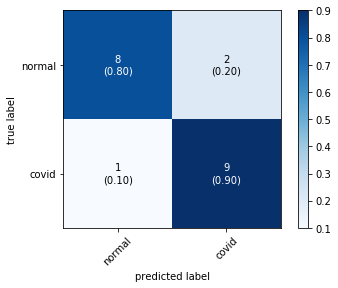

In [30]:
fig, ax = plot_confusion_matrix(conf_mat=cm, 
                                class_names=CLASS_NAMES,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

**Bewertung** Das Modell erzielt also eine Genauigkeit von 85% (=17/20). Weiterhin sind die Werte *Precision* und *Recall* interessant. Von allen COVID-19 positiven Fällen werden 90% (=9/10; Recall) durch das Modell erkannt. Bestimmt das Modell ein Bild als COVID-19 positiv, dann liegt es zu 82% (=9/11; Precision) richtig. Die Werte sind dabei kritisch zu betrachten - es kann argumentiert werden, dass das Modell besser alle COVID-19 positiven Fälle erkennt und dafür Fehlklassifikationen bei den normalen Fällen in Kauf nimmt. Dadurch würden Patienten mit COVID-19 nicht fehlerhafterweise entlassen werden. Weitere Informationen zum Umgang mit statistischen Fehlergrößen (u. And. auch dem oben ebenfalls abzulesenden F1-Score) findet man beispielsweise in folgendem [Blogpost](https://koopingshung.com/blog/machine-learning-model-selection-accuracy-precision-recall-f1/).

Abgesehen von den Werten selbst, soll erwähnt werden, dass die Anzahl an Validierungsdaten sehr gering ist und daher keine statistisch signifikante Aussage über die Güte des Modells getroffen werden kann.

Abschließend können die Performancemetriken des Modells während des Trainingsprozesses noch visualiert werden:

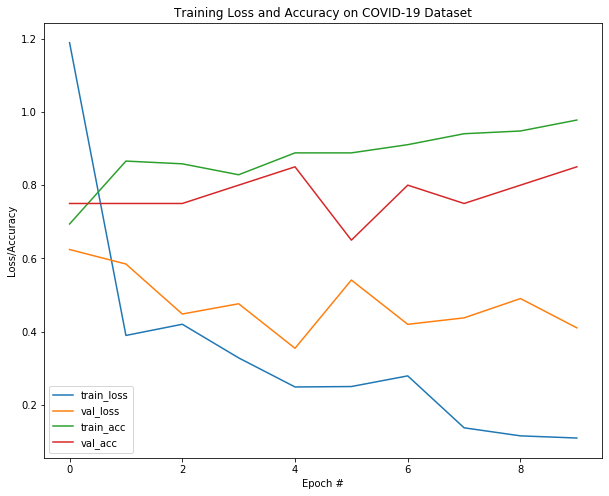

In [31]:
N = EPOCHS
#plt.style.use("ggplot")
plt.figure(figsize=(10,8))
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

Der Plot zeigt einen (tendenziellen) Abstieg des Trainings- und Validierungsverlustes. Der Trainingsverlust unterschreitet den Validierungsverlust allerdings erheblich. Dies könnte auf ein leichtes *Overfitting* des Modells hindeuten. Auch diese Aussage ist mit den geringen Datenbeständen allerdings nur schwer zu validieren. Weitere Informationen zur *Kapazität* eines Deep Learning-Modells finden sich Kapitel 5.2 von [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html).

**Bemerkung zur Reproduzierbarkeit**: Man vergleiche die hier dargestellten Ergebnisse auf einem ThinkPad P71 mit denen, die auf einem [ASUS Laptop](Projektvorstellung_TF_Covid19_Erg_ASUS.html) erzielt wurden. Das dort gefundene Modell (mit Hilfe der [Kurzform](Projektvorstellung_TF_Covid19_short.ipynb) dieses Notebooks) ist sicher nicht geeignet, obwohl es mit den gleichen Parametern (inkl. Random Seeds) trainiert wurde.

## Deployment

> **Aus CRISP-DM 1.0:** *Die Erstellung des Modells bedeutet im Allgemeinen nicht das Ende des Projekts. Auch wenn der Zweck des Modells darin besteht, das Wissen über die Daten zu erweitern, müssen die gewonnenen Erkenntnisse so organisiert und präsentiert werden, dass der Kunde sie nutzen kann. Dies beinhaltet oft die Anwendung von "Live"-Modellen innerhalb der Entscheidungsfindungsprozesse einer Organisation - zum Beispiel in der Echtzeit-Personalisierung von Webseiten oder der wiederholten Bewertung von Marketingdatenbanken. Je nach den Anforderungen kann die Deployment Phase so einfach sein wie die Erstellung eines Berichts oder so komplex wie die Implementierung eines wiederholbaren Data Mining-Prozesses im gesamten Unternehmen. In vielen Fällen ist es der Kunde, der die Bereitstellung durchführt und nicht der Data Scientist. Aber selbst wenn der Data Scientist die Bereitstellung durchführt, ist es für den Kunden wichtig zu verstehen, welche Aktionen durchgeführt werden müssen, um die erstellten Modelle tatsächlich zu nutzen*

In dieser Phase soll das Modell in die Anwendung gebracht, also *ausgerollt* werden. Für dieses Beispielprojekt könnte man sich die Implementierung einer API vorstellen, mit der Röntgenbilder über bestehende Systeme klassifiziert werden könnten und dann z.B. als Zweitmeinung für den behandelten Arzt exisitieren. Unzählige weitere Anwendungen sind denkbar. Die Umsetzung dieser Use Cases sprengt allerdings den Rahmen dieser Projektvorstellung und bleibt den Teilnehmern überlassen. Es sei jedoch gesagt, dass alle Tensorflow-Modelle gespeichert, exportiert und portiert werden können. Nähere Informationen findet man unter [Tensorflow TFX](https://www.tensorflow.org/tfx).

## Wie geht es weiter?

### Mögliche Verbesserungen

Das hier vorgestellte Deep Learning-Modell soll als Einstieg in die Thematik dienen und ist daher eher als ein *Grundgerüst* zu verstehen, welches noch an einigen Stellen verbessert werden kann. Diese Verbesserungen obliegen den Teilnehmern, wobei in diesem Abschnitt diverse Verbesserungsansätze (ohne Anspruch auf Vollständigkeit) aufgezeigt werden sollen:

* **Anpassung von Hyperparametern:** Die Hyperparameter sind jene Parameter, die das Netzwerk nicht selbst während des Trainings anpasst (*lernt*), sondern die vom Anwender vor Trainingsbeginn gesetzt werden. Dazu gehört beispielsweise die *Lernrate*, die *Batchsize*, die Anzahl der *Epochen*, die Art des *Optimierers* und die Architektur des Netzwerks selbst, sowie viele Weitere. Die Werte dieser Parameter haben einen monumentalen Effekt auf das Training des neuronalen Netzwerks und bilden oft ein instabiles Konstrukt, wodurch kleine Änderungen oft schon große Auswirkungen auf die Effektivität des resultierenden Netzwerks haben können. Die Einstellung der Hyperparameter erfordert daher zumindest ein grundlegendes Verständnis über deren Wirkungsweise. Die Anpassung kann dann in einem *Trial-and-Error*-Verfahren erfolgen. Eine elegantere Herangehensweise ist die Verwendung von (stochastischen) Suchalgorithmen, welche in einem gegebenen Hyperparameterraum das beste Modell finden. Eine einfache Implementierung solcher Algorithmen findet sich u.a. in der `keras-tuner`-[Bibliothek](https://keras-team.github.io/keras-tuner/).
* **Training des baseModel:** In unserem Beispiel wurde lediglich das *headModel* trainiert und die Layer des *baseModel* eingefroren. In der Praxis macht es allerdings Sinn, nach diesem initialen Trainingslauf auch die Gewichte des Basismodells für ein Training freizugeben. Intuitiv sollen die voreingestellten Gewichte dadurch noch in *Feineinstellungen* an den gegebenen Anwendungsfall angepasst werden. Hinweise über eine potentielle Vorgehensweise gibt es in diesem offiziellen [Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).
* **Verwendung eines anderen Modells:** Die Modell-Architektur des neuronalen Netzes in diesem Notebook wird als *DenseNet* bezeichnet. Dieses CNN aus [2016](https://arxiv.org/abs/1608.06993) liefert *Out-of-the-box* ganz passable Ergebnisse und folgt modernen Ansätzen zur Regularisierung eines tiefen Netzwerks. Konkret werden bei einem DenseNet ganze Layer während des Trainings immer wieder mal "ausgeschaltet" (also quasi *übersprungen*). Diese Architektur hat einige Vorteile, aber vielleicht ist sie für den vorliegenden Anwendungsfall nicht besonders gut geeignet. Tensorflow bietet in `tf.keras.applications` eine ganze Reihe von vortrainierten Netzwerken, mit denen gerne weitere Versuche gestartet werden können. Ein Überblick findet sich in der offiziellen [Doku](https://www.tensorflow.org/api_docs/python/tf/keras/applications). Dem geneigten Leser wird empfohlen, sich vor der Anwendung eines anderen Netzwerks einen kurzen theoretischen Überblick zu verschaffen und dann in empirischer Art und Weise *auszuprobieren*. 
* **Mehr Daten sammeln:** Ein Deep Learning-Modell (und Machine Learning-Modelle im Allgemeinen) lässt sich immer mit mehr Trainingsdaten verbessern. Intuitiv erlernt das Modell dadurch eine Repräsentation der Daten, welche der tatsächlichen Verteilung der Daten besser entspricht. Weiterhin skalieren Deep Learning-Modelle linear mit mehr Daten (gute Intuition von [Kilian Weinberger (9:40)](https://youtu.be/kPXxbmBsFxs?t=579)). Ein weiterer Vorteil von einem größeren Datenbestand ist die Ausweitung der Validierungsdaten. Damit gelingt eine genauere Evaluation des Modells, welche für den Praxiseinsatz unerlässlich ist.
* **Data Augmentation:** Das Ziel eines Deep Learning-Modells ist es, möglichst gut zu *generalisieren* - also auch bisher ungesehene und neue Daten korrekt zu verarbeiten. Eine Möglichkeit diese Generalisierungseigenschaft zu fördern ist die künstliche Erweiterung der Trainingsdaten. Dieser Prozess wird als *Data Augmentation* bezeichnet und umfasst in der Bildverarbeitung mehrere Ansätze. Im Kern sollen die Trainingsbilder derart verändert werden, dass diese immernoch korrekt das zugrundeliegende Motiv wiedergeben, aber vom Original abweichen. Dies erreicht man beispielsweise durch Spiegelung der Bilder (*Flipping*), Änderung der Farbstufen, Änderung des Bildausschnittes (*Cropping*), Rotation und vieles mehr. Das neuronale Netz soll dadurch *robuster* werden und besser generalisieren. Hinweise auf eine Umsetzung können dem offiziellen Tensorflow [Tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation) entnommen werden. **Vorsicht:** Nicht alle Data Augmentation-Methodiken eignen sich für die vorliegenden Daten! Bei Röntgenbildern kann beispielsweise eine Änderung der Farbstufen oder Spiegelung der Bilder das zugrundeliegende Bild invalidieren.

Für alle Anpassungen des Modells muss allerdings stets ein Grundsatz beachtet werden, welcher als ein **zentrales Problem des Machine Learning** verstanden werden kann: **Underfitting vs Overfitting!** Dieser [Blogpost](https://www.analyticsvidhya.com/blog/2020/02/underfitting-overfitting-best-fitting-machine-learning/) gibt einen guten, nicht-technischen Überblick über das Problem. 

Intuitiv wollen wir ein Deep Learning-Modell erhalten, welches durch das Trainingsprozedere ein *Verständnis* für die zugrundeliegenden Daten erreicht und dieses Verständnis auf neue Daten übertragen kann. Problematisch wird es, wenn das Modell: A) dieses Verständnis nie erreicht, da das Problem für das verwendete Modell zu komplex ist oder B) das Modell die Trainingsdaten lediglich *auswendig* lernt und damit die Fähigkeit zur *Generalisierung* neuer Daten verliert. Im Falle A) spricht man von *Underfitting* und bei B) handelt es sich um *Overfitting*. Die *Kapazität* des Modells, also dessen Potential mit komplexen Datenstrukturen umzugehen, muss immer im Verhältnis zu den vorliegenden Daten stehen. Die beiden Regime sollen durch folgende Abbildung verdeutlicht werden:

![Kapazität](./images/capacity_s.png "Kapazität")

In der Praxis existieren daher handfeste Strategien die Kapazität eines Modells anzupassen und damit Overfitting bzw. Underfitting zu vermeiden. Dieses Tensorflow [Tutorial](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) gibt beispielsweise einen guten Einstieg. Wer sich näher mit der Theorie der Modellkapazität beschäftigen möchte, dem wird erneut Kapitel 5.2 von [Ian Goodfellow et al.](https://www.deeplearningbook.org/contents/ml.html) ans Herz gelegt.

### Ausblick

Im Rahmen des Projektes soll ein Deep Learning-Modell in die Praxis überführt werden. Anders ausgedrückt: das Modell soll in einem Frontend zum Einsatz kommen. Dafür müssen die Themen *Export* und *Deployment/Implementierung* geklärt werden. Eine sinnvolle Herangehensweise soll von den Teilnehmern erarbeitet werden. Bei der Verwendung von Tensorflow sollte gegebenenfalls [Tensorflow TFX](https://www.tensorflow.org/tfx) untersucht werden, wobei unzählige weitere Möglichkeiten der Bereitstellung bestehen.

Abseits von der in diesem Notebook dargestellten Aufgabe der *Bildklassifikation* gibt es noch einige andere bildbezogene Anwendungsfälle im Deep Learning. Einige der spannendsten sind:
* **Object Detection:** Anstatt ein gesamtes Bild zu klassifizieren, werden durch Object Detection einzelne Objekte innerhalb eines Bildes klassifiziert und lokalisiert. Eine Einführung in die Thematik gibt beispielsweise [Jason Brownlee](https://machinelearningmastery.com/object-recognition-with-deep-learning/). Eine Subkategorie stellt die Object Segmentation dar, also die pixelgenaue Abgrenzung einzelner Objekte im Bild. Nähere Informationen gibt es beispielweise in einem Tensorflow [Tutorial](https://www.tensorflow.org/tutorials/images/segmentation).
* **Generative Adversarial Models:** *Generative Adversarial Networks (GANs)* funktionieren etwas anders, als das bisher vorgestellte Modell. Zum einen ist der Output eines GAN nicht etwa eine Klassifikation, sondern ein Bild. Desweiteren besteht ein GAN aus zwei neuronalen Netzen, welche gegeneinander in einen Wettstreit treten um neue, synthetische Instanzen von Daten zu erzeugen, welche echten Daten oft zum verwechseln ähnlich sind. GANs werden vorwiegend für Image Generation, Video Generation (Stichwort: *Deep Fakes*), aber auch Voice Generation verwendet. Eine spielerische Einführung zu Image Generation über eine moderne Variante, GANILLA, gibt [Two Minute Papers](https://www.youtube.com/watch?v=-IbNmc2mTz4&t=). Eine ebenso gelungene, aber technischere Einführung gibt es von [Arxiv Insights](https://www.youtube.com/watch?v=dCKbRCUyop8). Auch für Deep Fakes gibt es eine unterhaltsame Episode bei [Two Minute Papers](https://www.youtube.com/watch?v=mUfJOQKdtAk).

### Mehr Intuition entwickeln

Vielleicht haben Sie bereits mitbekommen, dass Neuronale Netze besonders gut auf Grafikkarten trainiert werden können, weshalb sich etwa die Firma [Nvidia mit KI profiliert](https://www.nvidia.com/de-de/deep-learning-ai/education/). Wenn man dort einen Developer Account anlegt, dann kann man einige freie Kurse belegen (eigentlich eher Tutorials), die ebenfalls mit Jupyter Notebooks wie dem vorliegenden unterstützt werden. Zu diesem Notebook passt etwa der Grundlagenkurs [Bildklassifizierung mit DIGITS](https://courses.nvidia.com/courses/course-v1:DLI+L-FX-01+V1/about), der ca. 2 Stunden dauert und einige der in diesem Notebook vorgestellten Aspekte mit anderen Worten und etwas anderer Perspektive erklärt und somit eine sehr gute Ergänzung darstellt.